<a href="https://colab.research.google.com/github/ijethmal/SC3000/blob/main/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

In [5]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

  Using cached pygame-2.1.0.tar.gz (5.8 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


## Importing dependencies and define helper functions

In [25]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from abc import ABC, abstractmethod

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [6]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [7]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [8]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [14]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [0.03190004 0.02791234 0.03536061 0.00414912]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [15]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.03245828 -0.16769841  0.03544359  0.3077757 ]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [17]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 10.0


## Task 1: Development of an RL agent

Create the Monte Carlo agent

In [27]:
class MonteCarloAgent:
    def __init__(self, action_space_size, state_space_size):
        self.action_space_size = action_space_size
        self.state_space_size = state_space_size
        self.Q = np.zeros((state_space_size, action_space_size))  # initialize Q-table to zeros
        self.returns = {}  # dictionary to store returns for state-action pairs
        self.N = np.zeros((state_space_size, action_space_size))  # count visits to state-action pairs
        self.epsilon = 0.1  # exploration rate

    def discretize_state(self, observation):
        # state representation: 10x10x10x10 bins
        cart_pos_bins = np.linspace(-2.4, 2.4, 10)  # 10 bins for cart position
        cart_vel_bins = np.linspace(-2, 2, 10)  # 10 bins for cart velocity
        pole_angle_bins = np.linspace(-0.418, 0.418, 10)  # 10 bins for pole angle
        pole_vel_bins = np.linspace(-2, 2, 10)  # 10 bins for pole velocity

        state = (np.digitize(observation[0], cart_pos_bins),
                 np.digitize(observation[1], cart_vel_bins),
                 np.digitize(observation[2], pole_angle_bins),
                 np.digitize(observation[3], pole_vel_bins))

        # Convert the tuple to a unique integer state representation
        state_index = state[0] * (10**3) + state[1] * (10**2) + state[2] * (10**1) + state[3]

        return state_index


    def choose_action(self, state):
        # epsilon-greedy action selection
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(self.action_space_size)  # Explore
        else:
            return np.argmax(self.Q[state, :])  # Exploit

    def update_Q(self, episode):
        # Update Q-values using the Monte Carlo method
        G = 0
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = 1.0 * G + reward  # Assuming discount factor gamma = 1

            # Update returns and visit counts
            if (state, action) not in self.returns:
                self.returns[(state, action)] = []
            self.returns[(state, action)].append(G)
            self.N[state, action] += 1

            # Update Q-value
            self.Q[state, action] = np.mean(self.returns[(state, action)])

## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

In [28]:
# Assuming your state space is discretized into 10000 states
state_space_size = 10000
action_space_size = env.action_space.n  # Number of actions (2 in CartPole)

agent = MonteCarloAgent(action_space_size, state_space_size)

num_episodes = 100
episode_results = []

for episode_num in range(num_episodes):
    observation = env.reset()
    episode = []
    cumulative_reward = 0
    done = False

    while not done:
        state = agent.discretize_state(observation)
        action = agent.choose_action(state)
        observation, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        cumulative_reward += reward

    agent.update_Q(episode)  # Update Q-values after each episode
    episode_results.append(cumulative_reward)

    print(f"Episode {episode_num + 1}: Cumulative Reward = {cumulative_reward}")

# ... (Your plotting code remains the same) ...

Episode 1: Cumulative Reward = 10.0
Episode 2: Cumulative Reward = 9.0
Episode 3: Cumulative Reward = 9.0
Episode 4: Cumulative Reward = 15.0
Episode 5: Cumulative Reward = 23.0
Episode 6: Cumulative Reward = 10.0
Episode 7: Cumulative Reward = 34.0
Episode 8: Cumulative Reward = 26.0
Episode 9: Cumulative Reward = 17.0
Episode 10: Cumulative Reward = 40.0
Episode 11: Cumulative Reward = 39.0
Episode 12: Cumulative Reward = 19.0
Episode 13: Cumulative Reward = 26.0
Episode 14: Cumulative Reward = 19.0
Episode 15: Cumulative Reward = 24.0
Episode 16: Cumulative Reward = 20.0
Episode 17: Cumulative Reward = 29.0
Episode 18: Cumulative Reward = 12.0
Episode 19: Cumulative Reward = 13.0
Episode 20: Cumulative Reward = 33.0
Episode 21: Cumulative Reward = 8.0
Episode 22: Cumulative Reward = 25.0
Episode 23: Cumulative Reward = 23.0
Episode 24: Cumulative Reward = 39.0
Episode 25: Cumulative Reward = 21.0
Episode 26: Cumulative Reward = 45.0
Episode 27: Cumulative Reward = 42.0
Episode 28: C

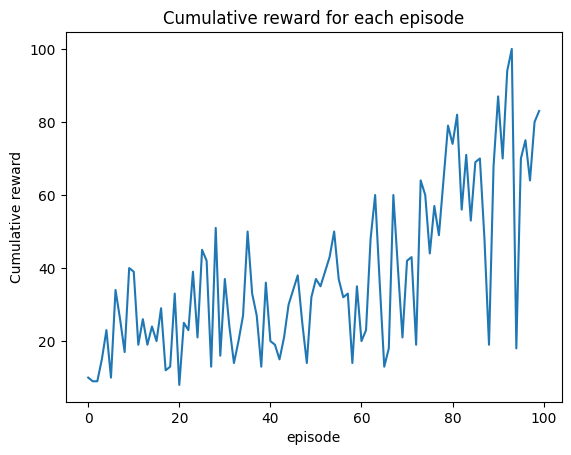

In [29]:
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [32]:
print(episode_results)
mean = sum(episode_results) / len(episode_results)
print(mean)

[10.0, 9.0, 9.0, 15.0, 23.0, 10.0, 34.0, 26.0, 17.0, 40.0, 39.0, 19.0, 26.0, 19.0, 24.0, 20.0, 29.0, 12.0, 13.0, 33.0, 8.0, 25.0, 23.0, 39.0, 21.0, 45.0, 42.0, 13.0, 51.0, 16.0, 37.0, 24.0, 14.0, 20.0, 27.0, 50.0, 33.0, 27.0, 13.0, 36.0, 20.0, 19.0, 15.0, 21.0, 30.0, 34.0, 38.0, 25.0, 14.0, 32.0, 37.0, 35.0, 39.0, 43.0, 50.0, 37.0, 32.0, 33.0, 14.0, 35.0, 20.0, 23.0, 48.0, 60.0, 36.0, 13.0, 18.0, 60.0, 40.0, 21.0, 42.0, 43.0, 19.0, 64.0, 60.0, 44.0, 57.0, 49.0, 64.0, 79.0, 74.0, 82.0, 56.0, 71.0, 53.0, 69.0, 70.0, 48.0, 19.0, 68.0, 87.0, 70.0, 94.0, 100.0, 18.0, 70.0, 75.0, 64.0, 80.0, 83.0]
38.05


In [34]:
print("Average cumulative reward:", mean)
print("Is my agent good enough?", mean > 195)

Average cumulative reward: 38.05
Is my agent good enough? False


## Task 3: Render one episode played by the agent

In [40]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()

# Assuming you have already defined and trained your MonteCarloAgent (agent)
# and have state_space_size and action_space_size defined

# Initialize the agent here (if not already done)
agent = MonteCarloAgent(action_space_size, state_space_size)

while True:
    env.render()

    # Get the current state and discretize it
    state = agent.discretize_state(observation)

    # Choose an action using the agent's policy
    action = agent.choose_action(state)

    observation, reward, done, info = env.step(action)
    if done:
      break;
env.close()
show_video()

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Plug your agent to the code below to obtain rendered result.